## BTC Option Volatility Time Series

In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [98]:
plt.rcParams["figure.figsize"] = (16, 10)

### Generate underlying index price time series

At the moment we do not record the index prices so it must be obtained from option data by naively assuming that the largest data file contains the most index price data. Fix this in future.

In [99]:
csv_path = '/home/fp361/cloud-mounts/deribit_orderbook_data/'

In [100]:
import os

In [101]:
csv_list = os.listdir(csv_path)

pairs = []
for file in csv_list:

    location = os.path.join(csv_path, file)

    size = os.path.getsize(location)
    pairs.append((size, file))

pairs.sort(key=lambda s: s[0])

pairs.reverse()
largest = pairs[0]
print(largest)

(5317357, 'BTC-26JUN20-9000-C.csv')


In [128]:
index_prices = pd.read_csv(os.path.join(csv_path, largest[1])).filter(['timestamp', 'index_price'])
index_prices['timestamp'] = pd.to_datetime(index_prices['timestamp'], unit='ms')
index_prices = index_prices.set_index('timestamp')
index_prices

,index_price
timestamp,
2020-03-29 17:47:00.926,6107.48
2020-03-29 17:49:13.858,6106.78
2020-03-29 17:50:52.549,6106.66
2020-03-29 17:52:27.221,6107.50
2020-03-29 17:56:12.810,6118.13
...,...
2020-04-20 15:19:46.034,7084.06
2020-04-20 15:23:45.701,7091.42
2020-04-20 15:27:45.366,7095.29


In [129]:
index_prices_5min = pd.DataFrame()
index_prices_5min['index_price'] = index_prices.index_price.resample('5min').last()
index_prices_5min

,index_price
timestamp,
2020-03-29 17:45:00,6106.78
2020-03-29 17:50:00,6107.50
2020-03-29 17:55:00,6118.13
2020-03-29 18:00:00,6099.96
2020-03-29 18:05:00,6101.16
...,...
2020-04-20 15:15:00,7084.06
2020-04-20 15:20:00,7091.42
2020-04-20 15:25:00,7095.29


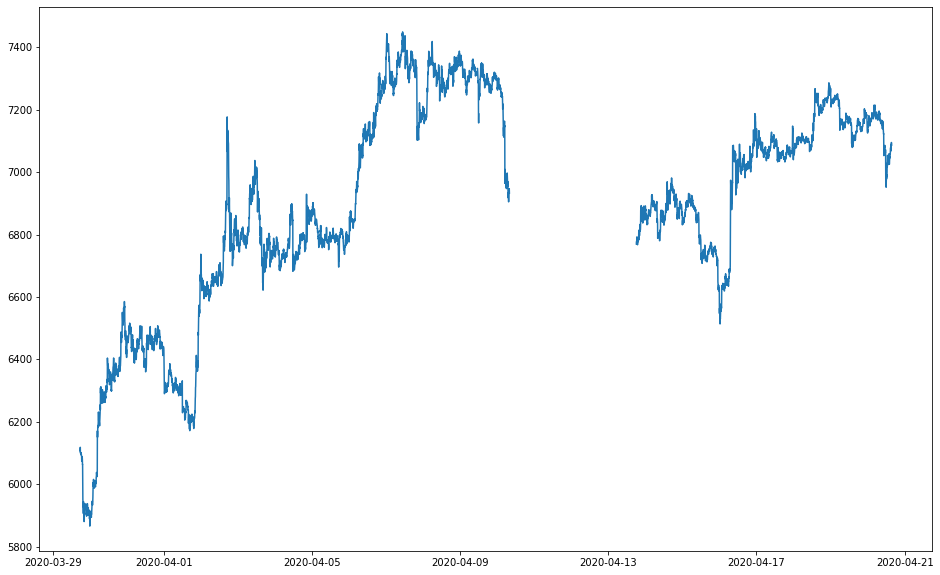

In [130]:
plt.plot(index_prices_5min)

### Function to load required orderbook data

In [5]:
import glob

# Shorthand for dictionary lookup
co = 'C' # Call option
po = 'P' # Put option

In [78]:
def read_orderbook_data(csv_paths, expiry, data_dict=dict()):
    if expiry not in data_dict:
        data_dict[expiry] = dict()
    else:
        # Already read
        return data_dict
    
    near_next_csv = list()
    for path in csv_paths:
        near_next_csv += glob.glob(path + f'BTC-{expiry}-*-*.csv')
    
    #if len(near_next_csv) == 0:
    #    raise ValueError(f'{expiry} data unavailable!')
        
    print(f'Reading {expiry} data from disk...')
    for file_path in near_next_csv:
        instrument = os.path.basename(file_path).split('-')
        exp, strike, cp = instrument[1], int(instrument[2]), instrument[3].split('.')[0]  

        if strike not in data_dict[exp]:
            data_dict[exp][strike] = dict()
        try:    
            df = pd.read_csv(file_path).filter(['timestamp', 'best_bid_price', 'best_ask_price'])
            df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms', errors='coerce')
            df = df.set_index('timestamp')
            df_resampled = df.resample('5min').last().dropna()
        except Exception as e:
            print('ERROR', file_path, e)
            
        data_dict[exp][strike][cp] = df_resampled
        
    return data_dict        

Test:

In [7]:
# This call should return a five-minute resampled time-series dataframe of best bids and asks for BTC-3APR20-6750-C.
test = read_orderbook_data([csv_path], '3APR20')['3APR20'][6750][co]
test.head()

,best_bid_price,best_ask_price
timestamp,,
2020-03-29 17:45:00,0.009,0.011
2020-03-29 17:50:00,0.009,0.011
2020-03-29 17:55:00,0.009,0.011
2020-03-29 18:00:00,0.009,0.011
2020-03-29 18:05:00,0.009,0.011


## Volatility Indices

### Preparing data for vxbt_calc

For testing, pick random date and time.

In [8]:
now = pd.to_datetime('2020-01-24 00:00:00')

Import our *vxbt_calc* module.

In [9]:
from vxbt_calc import vxbt_calc

In [10]:
near_expiry, next_expiry, near_datetime, next_datetime = vxbt_calc.get_near_next_terms(now)
csv_path2 = '/home/fp361/bitfear/deribit-orderbook-scraper/scraped_data/'

orderbook_data = dict()
orderbook_data = read_orderbook_data([csv_path, csv_path2], near_expiry, orderbook_data)
orderbook_data = read_orderbook_data([csv_path, csv_path2], next_expiry, orderbook_data)

In [11]:
print(near_expiry, next_expiry)
print(orderbook_data.keys())

24JAN20 31JAN20
dict_keys(['24JAN20', '31JAN20'])


The xvbt_calc module requires four dataframes - near_calls_df, near_puts_df, next_calls_df, next_puts_df - to perform an offline index calculation.

In [77]:
def build_dataframes(time, near_expiry, next_expiry, data_dict):
    near_calls = dict()
    near_puts = dict()
    next_calls = dict()
    next_puts = dict()
    
    for strike in data_dict[near_expiry]:
        near_calls[strike] = data_dict[near_expiry][strike]['C'].loc[time].astype(float)
        near_puts[strike] = data_dict[near_expiry][strike]['P'].loc[time].astype(float)        
    
    for strike in data_dict[next_expiry]:
        next_calls[strike] = data_dict[next_expiry][strike]['C'].loc[time].astype(float)
        next_puts[strike] = data_dict[next_expiry][strike]['P'].loc[time].astype(float)
        
    near_calls_df = pd.DataFrame.from_dict(near_calls, orient='index').sort_index().replace(0, np.nan).rename(columns={'best_bid_price': 'best_bid', 'best_ask_price': 'best_ask'})
    near_puts_df = pd.DataFrame.from_dict(near_puts, orient='index').sort_index().replace(0, np.nan).rename(columns={'best_bid_price': 'best_bid', 'best_ask_price': 'best_ask'})
    next_calls_df = pd.DataFrame.from_dict(next_calls, orient='index').sort_index().replace(0, np.nan).rename(columns={'best_bid_price': 'best_bid', 'best_ask_price': 'best_ask'})
    next_puts_df = pd.DataFrame.from_dict(next_puts, orient='index').sort_index().replace(0, np.nan).rename(columns={'best_bid_price': 'best_bid', 'best_ask_price': 'best_ask'})
    
    return near_calls_df, near_puts_df, next_calls_df, next_puts_df

In [16]:
dfs = build_dataframes(now, near_expiry, next_expiry, orderbook_data)
dfs[0]

,best_bid,best_ask
6250,0.2455,0.2645
6500,0.2155,0.2335
6750,0.1855,0.2045
7000,0.1550,0.1750
7250,0.1250,0.1455
7500,0.0935,0.1150
7750,0.0670,0.0845
8000,0.0385,0.0545
8250,0.0155,0.0175
8500,0.0015,0.0020


In [17]:
vxbt_calc.get_indices(live=False, time=now, dfs=dfs)

(0.12502294506433326, 3.5935535388512494, 0.0004227703956517935)

### Computing the time series

In [24]:
import datetime

In [91]:
orderbook_data = dict()

now = pd.to_datetime('2020-01-01 00:00:00')
end = datetime.datetime.now()

indices_df = pd.DataFrame(columns=['timestamp', 'vxbt', 'gvxbt', 'avxbt'])

while now < end:
    near_expiry, next_expiry, near_datetime, next_datetime = vxbt_calc.get_near_next_terms(now)
    
    orderbook_data = read_orderbook_data([csv_path, csv_path2], near_expiry, orderbook_data)
    orderbook_data = read_orderbook_data([csv_path, csv_path2], next_expiry, orderbook_data)
    
    if not orderbook_data[near_expiry] or not orderbook_data[next_expiry]:
        print(f'WARNING: Insufficient data at {now}')
        now += datetime.timedelta(minutes=5)
        continue

    try:
        dfs = build_dataframes(now, near_expiry, next_expiry, orderbook_data)
        VXBT, GVXBT, AVXBT = vxbt_calc.get_indices(live=False, time=now, dfs=dfs)
        
        indices_df = indices_df.append({'timestamp': now, 'vxbt': VXBT, 'gvxbt': GVXBT, 'avxbt': AVXBT}, ignore_index=True)
    #except KeyError:
    #    print(f'WARNING: Insufficient data at {now}')
    except Exception as e:
        print(f'WARNING: Unhandled error at {now}')
        print(e)
    
    now += datetime.timedelta(minutes=5)


Reading 3JAN20 data from disk...
Reading 10JAN20 data from disk...


Reading 17JAN20 data from disk...


Reading 24JAN20 data from disk...


Reading 31JAN20 data from disk...
Timestamp('2020-01-17 08:05:00')
Timestamp('2020-01-17 08:10:00')
Timestamp('2020-01-17 08:15:00')
Timestamp('2020-01-17 08:20:00')
Timestamp('2020-01-17 08:25:00')
Timestamp('2020-01-17 08:30:00')
Timestamp('2020-01-17 08:35:00')
Timestamp('2020-01-17 08:40:00')
Timestamp('2020-01-17 08:45:00')
Timestamp('2020-01-17 08:50:00')
Timestamp('2020-01-17 08:55:00')
Timestamp('2020-01-17 09:00:00')
Timestamp('2020-01-17 09:05:00')
Timestamp('2020-01-17 09:10:00')
Timestamp('2020-01-17 09:15:00')
Timestamp('2020-01-17 09:20:00')
Timestamp('2020-01-17 09:25:00')
Timestamp('2020-01-17 09:30:00')
Timestamp('2020-01-17 09:35:00')
Timestamp('2020-01-17 09:40:00')
Timestamp('2020-01-17 09:45:00')
Timestamp('2020-01-17 09:50:00')
Timestamp('2020-01-17 09:55:00')
Timestamp('2020-01-17 10:00:00')
Timestamp('2020-01-17 10:05:00')
Timestamp('2020-01-17 10:10:00')
Timestamp('2020-01-17 10:15:00')
Timestamp('2020-01-17 10:20:00')
Timestamp('2020-01-17 10:25:00')
Timestamp

Timestamp('2020-01-18 20:25:00')
Timestamp('2020-01-18 20:30:00')
Timestamp('2020-01-18 20:35:00')
Timestamp('2020-01-18 20:40:00')
Timestamp('2020-01-18 20:45:00')
Timestamp('2020-01-18 20:50:00')
Timestamp('2020-01-18 20:55:00')
Timestamp('2020-01-18 21:00:00')
Timestamp('2020-01-18 21:05:00')
Timestamp('2020-01-18 21:10:00')
Timestamp('2020-01-18 21:15:00')
Timestamp('2020-01-18 21:20:00')
Timestamp('2020-01-18 21:25:00')
Timestamp('2020-01-18 21:30:00')
Timestamp('2020-01-18 21:35:00')
Timestamp('2020-01-18 21:40:00')
Timestamp('2020-01-18 21:45:00')
Timestamp('2020-01-18 21:50:00')
Timestamp('2020-01-18 21:55:00')
Timestamp('2020-01-18 22:00:00')
Timestamp('2020-01-18 22:05:00')
Timestamp('2020-01-18 22:10:00')
Timestamp('2020-01-18 22:15:00')
Timestamp('2020-01-18 22:20:00')
Timestamp('2020-01-18 22:25:00')
Timestamp('2020-01-18 22:30:00')
Timestamp('2020-01-18 22:35:00')
Timestamp('2020-01-18 22:40:00')
Timestamp('2020-01-18 22:45:00')
Timestamp('2020-01-18 22:50:00')
Timestamp(

Timestamp('2020-01-20 10:10:00')
Timestamp('2020-01-20 10:15:00')
Timestamp('2020-01-20 10:20:00')
Timestamp('2020-01-20 10:25:00')
Timestamp('2020-01-20 10:30:00')
Timestamp('2020-01-20 10:35:00')
Timestamp('2020-01-20 10:40:00')
Timestamp('2020-01-20 10:45:00')
Timestamp('2020-01-20 10:50:00')
Timestamp('2020-01-20 10:55:00')
Timestamp('2020-01-20 11:00:00')
Timestamp('2020-01-20 11:05:00')
Timestamp('2020-01-20 11:10:00')
Timestamp('2020-01-20 11:15:00')
Timestamp('2020-01-20 11:20:00')
Timestamp('2020-01-20 11:25:00')
Timestamp('2020-01-20 11:30:00')
Timestamp('2020-01-20 11:35:00')
Timestamp('2020-01-20 11:40:00')
Timestamp('2020-01-20 11:45:00')
Timestamp('2020-01-20 11:50:00')
Timestamp('2020-01-20 11:55:00')
Timestamp('2020-01-20 12:00:00')
Timestamp('2020-01-20 12:05:00')
Timestamp('2020-01-20 12:10:00')
Timestamp('2020-01-20 12:15:00')
Timestamp('2020-01-20 12:20:00')
Timestamp('2020-01-20 12:25:00')
Timestamp('2020-01-20 12:30:00')
Timestamp('2020-01-20 12:35:00')
Timestamp(

Timestamp('2020-01-21 11:00:00')
Timestamp('2020-01-21 11:05:00')
Timestamp('2020-01-21 11:10:00')
Timestamp('2020-01-21 11:15:00')
Timestamp('2020-01-21 11:20:00')
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
cannot do label indexing on <class 'pandas.core.indexes.numeric.Int64Index'> with these indexers [nan] of <class 'float'>
cannot do label indexing on <class 'pandas.core.indexes.numeric.Int64Index'> with these indexers [nan] of <class 'float'>
cannot do label indexing on <class 'pandas.core.indexes.numeric.Int64Index'> with these indexers [nan] of <class 'float'>
cannot do label indexing on <class 'pandas.core.indexes.numeric.Int64Index'> with these indexers [nan] of <class 'float'>
cannot do label indexing on <class 'pandas.core.indexes.numeric.Int64Index'> with these i

Reading 14FEB20 data from disk...


Reading 21FEB20 data from disk...


Reading 28FEB20 data from disk...


Reading 6MAR20 data from disk...


Reading 13MAR20 data from disk...


Reading 20MAR20 data from disk...


Reading 27MAR20 data from disk...


Reading 3APR20 data from disk...


Timestamp('2020-03-20 08:05:00')
Timestamp('2020-03-20 08:10:00')
Timestamp('2020-03-20 08:15:00')
Timestamp('2020-03-20 08:20:00')
Timestamp('2020-03-20 08:25:00')
Timestamp('2020-03-20 08:30:00')
Timestamp('2020-03-20 08:35:00')
Timestamp('2020-03-20 08:40:00')
Timestamp('2020-03-20 08:45:00')
Timestamp('2020-03-20 08:50:00')
Timestamp('2020-03-20 08:55:00')
Timestamp('2020-03-20 09:00:00')
Timestamp('2020-03-20 09:05:00')
Timestamp('2020-03-20 09:10:00')
Timestamp('2020-03-20 09:15:00')
Timestamp('2020-03-20 09:20:00')
Timestamp('2020-03-20 09:25:00')
Timestamp('2020-03-20 09:30:00')
Timestamp('2020-03-20 09:35:00')
Timestamp('2020-03-20 09:40:00')
Timestamp('2020-03-20 09:45:00')
Timestamp('2020-03-20 09:50:00')
Timestamp('2020-03-20 09:55:00')
Timestamp('2020-03-20 10:00:00')
Timestamp('2020-03-20 10:05:00')
Timestamp('2020-03-20 10:10:00')
Timestamp('2020-03-20 10:15:00')
Timestamp('2020-03-20 10:20:00')
Timestamp('2020-03-20 10:25:00')
Timestamp('2020-03-20 10:30:00')
Timestamp(

Timestamp('2020-03-22 06:25:00')
Timestamp('2020-03-22 06:30:00')
Timestamp('2020-03-22 06:35:00')
Timestamp('2020-03-22 06:40:00')
Timestamp('2020-03-22 06:45:00')
Timestamp('2020-03-22 06:50:00')
Timestamp('2020-03-22 06:55:00')
Timestamp('2020-03-22 07:00:00')
Timestamp('2020-03-22 07:05:00')
Timestamp('2020-03-22 07:10:00')
Timestamp('2020-03-22 07:15:00')
Timestamp('2020-03-22 07:20:00')
Timestamp('2020-03-22 07:25:00')
Timestamp('2020-03-22 07:30:00')
Timestamp('2020-03-22 07:35:00')
Timestamp('2020-03-22 07:40:00')
Timestamp('2020-03-22 07:45:00')
Timestamp('2020-03-22 07:50:00')
Timestamp('2020-03-22 07:55:00')
Timestamp('2020-03-22 08:00:00')
Timestamp('2020-03-22 08:05:00')
Timestamp('2020-03-22 08:10:00')
Timestamp('2020-03-22 08:15:00')
Timestamp('2020-03-22 08:20:00')
Timestamp('2020-03-22 08:25:00')
Timestamp('2020-03-22 08:30:00')
Timestamp('2020-03-22 08:35:00')
Timestamp('2020-03-22 08:40:00')
Timestamp('2020-03-22 08:45:00')
Timestamp('2020-03-22 08:50:00')
Timestamp(

Timestamp('2020-03-24 03:30:00')
Timestamp('2020-03-24 03:35:00')
Timestamp('2020-03-24 03:40:00')
Timestamp('2020-03-24 03:45:00')
Timestamp('2020-03-24 03:50:00')
Timestamp('2020-03-24 03:55:00')
Timestamp('2020-03-24 04:00:00')
Timestamp('2020-03-24 04:05:00')
Timestamp('2020-03-24 04:10:00')
Timestamp('2020-03-24 04:15:00')
Timestamp('2020-03-24 04:20:00')
Timestamp('2020-03-24 04:25:00')
Timestamp('2020-03-24 04:30:00')
Timestamp('2020-03-24 04:35:00')
Timestamp('2020-03-24 04:40:00')
Timestamp('2020-03-24 04:45:00')
Timestamp('2020-03-24 04:50:00')
Timestamp('2020-03-24 04:55:00')
Timestamp('2020-03-24 05:00:00')
Timestamp('2020-03-24 05:05:00')
Timestamp('2020-03-24 05:10:00')
Timestamp('2020-03-24 05:15:00')
Timestamp('2020-03-24 05:20:00')
Timestamp('2020-03-24 05:25:00')
Timestamp('2020-03-24 05:30:00')
Timestamp('2020-03-24 05:35:00')
Timestamp('2020-03-24 05:40:00')
Timestamp('2020-03-24 05:45:00')
Timestamp('2020-03-24 05:50:00')
Timestamp('2020-03-24 05:55:00')
Timestamp(

Timestamp('2020-03-25 12:40:00')
Timestamp('2020-03-25 12:45:00')
Timestamp('2020-03-25 12:50:00')
Timestamp('2020-03-25 12:55:00')
Timestamp('2020-03-25 13:00:00')
Timestamp('2020-03-25 13:05:00')
Timestamp('2020-03-25 13:10:00')
Timestamp('2020-03-25 13:15:00')
Timestamp('2020-03-25 13:20:00')
Timestamp('2020-03-25 13:25:00')
Timestamp('2020-03-25 13:30:00')
Timestamp('2020-03-25 13:35:00')
Timestamp('2020-03-25 13:40:00')
Timestamp('2020-03-25 13:45:00')
Timestamp('2020-03-25 13:50:00')
Timestamp('2020-03-25 13:55:00')
Timestamp('2020-03-25 14:00:00')
Timestamp('2020-03-25 14:05:00')
Timestamp('2020-03-25 14:10:00')
Timestamp('2020-03-25 14:15:00')
Timestamp('2020-03-25 14:20:00')
Timestamp('2020-03-25 14:25:00')
Timestamp('2020-03-25 14:30:00')
Timestamp('2020-03-25 14:35:00')
Timestamp('2020-03-25 14:40:00')
Timestamp('2020-03-25 14:45:00')
Timestamp('2020-03-25 14:50:00')
Timestamp('2020-03-25 14:55:00')
Timestamp('2020-03-25 15:00:00')
Timestamp('2020-03-25 15:05:00')
Timestamp(

Timestamp('2020-03-27 02:05:00')
Timestamp('2020-03-27 02:10:00')
Timestamp('2020-03-27 02:15:00')
Timestamp('2020-03-27 02:20:00')
Timestamp('2020-03-27 02:25:00')
Timestamp('2020-03-27 02:30:00')
Timestamp('2020-03-27 02:35:00')
Timestamp('2020-03-27 02:40:00')
Timestamp('2020-03-27 02:45:00')
Timestamp('2020-03-27 02:50:00')
Timestamp('2020-03-27 02:55:00')
Timestamp('2020-03-27 03:00:00')
Timestamp('2020-03-27 03:05:00')
Timestamp('2020-03-27 03:10:00')
Timestamp('2020-03-27 03:15:00')
Timestamp('2020-03-27 03:20:00')
Timestamp('2020-03-27 03:25:00')
Timestamp('2020-03-27 03:30:00')
Timestamp('2020-03-27 03:35:00')
Timestamp('2020-03-27 03:40:00')
Timestamp('2020-03-27 03:45:00')
Timestamp('2020-03-27 03:50:00')
Timestamp('2020-03-27 03:55:00')
Timestamp('2020-03-27 04:00:00')
Timestamp('2020-03-27 04:05:00')
Timestamp('2020-03-27 04:10:00')
Timestamp('2020-03-27 04:15:00')
Timestamp('2020-03-27 04:20:00')
Timestamp('2020-03-27 04:25:00')
Timestamp('2020-03-27 04:30:00')
Timestamp(

Timestamp('2020-03-29 04:55:00')
Timestamp('2020-03-29 05:00:00')
Timestamp('2020-03-29 05:05:00')
Timestamp('2020-03-29 05:10:00')
Timestamp('2020-03-29 05:15:00')
Timestamp('2020-03-29 05:20:00')
Timestamp('2020-03-29 05:25:00')
Timestamp('2020-03-29 05:30:00')
Timestamp('2020-03-29 05:35:00')
Timestamp('2020-03-29 05:40:00')
Timestamp('2020-03-29 05:45:00')
Timestamp('2020-03-29 05:50:00')
Timestamp('2020-03-29 05:55:00')
Timestamp('2020-03-29 06:00:00')
Timestamp('2020-03-29 06:05:00')
Timestamp('2020-03-29 06:10:00')
Timestamp('2020-03-29 06:15:00')
Timestamp('2020-03-29 06:20:00')
Timestamp('2020-03-29 06:25:00')
Timestamp('2020-03-29 06:30:00')
Timestamp('2020-03-29 06:35:00')
Timestamp('2020-03-29 06:40:00')
Timestamp('2020-03-29 06:45:00')
Timestamp('2020-03-29 06:50:00')
Timestamp('2020-03-29 06:55:00')
Timestamp('2020-03-29 07:00:00')
Timestamp('2020-03-29 07:05:00')
Timestamp('2020-03-29 07:10:00')
Timestamp('2020-03-29 07:15:00')
Timestamp('2020-03-29 07:20:00')
Timestamp(

Timestamp('2020-03-29 18:50:00')
Timestamp('2020-03-29 18:55:00')
Timestamp('2020-03-29 19:00:00')
Timestamp('2020-03-29 19:05:00')
Timestamp('2020-03-29 19:10:00')
Timestamp('2020-03-29 19:15:00')
Timestamp('2020-03-29 19:20:00')
Timestamp('2020-03-29 19:25:00')
Timestamp('2020-03-29 19:30:00')
Timestamp('2020-03-29 19:35:00')
Timestamp('2020-03-29 19:40:00')
Timestamp('2020-03-29 19:45:00')
Timestamp('2020-03-29 19:50:00')
Timestamp('2020-03-29 19:55:00')
Timestamp('2020-03-29 20:00:00')
Timestamp('2020-03-29 20:05:00')
Timestamp('2020-03-29 20:10:00')
Timestamp('2020-03-29 20:15:00')
Timestamp('2020-03-29 20:20:00')
Timestamp('2020-03-29 20:25:00')
Timestamp('2020-03-29 20:30:00')
Timestamp('2020-03-29 20:35:00')
Timestamp('2020-03-29 20:40:00')
Timestamp('2020-03-29 20:45:00')
Timestamp('2020-03-29 20:50:00')
Timestamp('2020-03-29 20:55:00')
Timestamp('2020-03-29 21:00:00')
Timestamp('2020-03-29 21:05:00')
Timestamp('2020-03-29 21:10:00')
Timestamp('2020-03-29 21:15:00')
Timestamp(

Timestamp('2020-03-30 04:05:00')
Timestamp('2020-03-30 04:10:00')
Timestamp('2020-03-30 04:15:00')
Timestamp('2020-03-30 04:20:00')
Timestamp('2020-03-30 04:25:00')
Timestamp('2020-03-30 04:30:00')
Timestamp('2020-03-30 04:35:00')
Timestamp('2020-03-30 04:40:00')
Timestamp('2020-03-30 04:45:00')
Timestamp('2020-03-30 04:50:00')
Timestamp('2020-03-30 04:55:00')
Timestamp('2020-03-30 05:00:00')
Timestamp('2020-03-30 05:05:00')
Timestamp('2020-03-30 05:10:00')
Timestamp('2020-03-30 05:15:00')
Timestamp('2020-03-30 05:20:00')
Timestamp('2020-03-30 05:25:00')
Timestamp('2020-03-30 05:30:00')
Timestamp('2020-03-30 05:35:00')
Timestamp('2020-03-30 05:40:00')
Timestamp('2020-03-30 05:45:00')
Timestamp('2020-03-30 05:50:00')
Timestamp('2020-03-30 05:55:00')
Timestamp('2020-03-30 06:00:00')
Timestamp('2020-03-30 06:05:00')
Timestamp('2020-03-30 06:10:00')
Timestamp('2020-03-30 06:15:00')
Timestamp('2020-03-30 06:20:00')
Timestamp('2020-03-30 06:25:00')
Timestamp('2020-03-30 06:30:00')
Timestamp(

Timestamp('2020-03-31 01:55:00')
Timestamp('2020-03-31 02:00:00')
Timestamp('2020-03-31 02:05:00')
Timestamp('2020-03-31 02:10:00')
Timestamp('2020-03-31 02:15:00')
Timestamp('2020-03-31 02:20:00')
Timestamp('2020-03-31 02:25:00')
Timestamp('2020-03-31 02:30:00')
Timestamp('2020-03-31 02:35:00')
Timestamp('2020-03-31 02:40:00')
Timestamp('2020-03-31 02:45:00')
Timestamp('2020-03-31 02:50:00')
Timestamp('2020-03-31 02:55:00')
Timestamp('2020-03-31 03:00:00')
Timestamp('2020-03-31 03:05:00')
Timestamp('2020-03-31 03:10:00')
Timestamp('2020-03-31 03:15:00')
Timestamp('2020-03-31 03:20:00')
Timestamp('2020-03-31 03:25:00')
Timestamp('2020-03-31 03:30:00')
Timestamp('2020-03-31 03:35:00')
Timestamp('2020-03-31 03:40:00')
Timestamp('2020-03-31 03:45:00')
Timestamp('2020-03-31 03:50:00')
Timestamp('2020-03-31 03:55:00')
Timestamp('2020-03-31 04:00:00')
Timestamp('2020-03-31 04:05:00')
Timestamp('2020-03-31 04:10:00')
Timestamp('2020-03-31 04:15:00')
Timestamp('2020-03-31 04:20:00')
Timestamp(

Timestamp('2020-03-31 17:25:00')
Timestamp('2020-03-31 17:30:00')
Timestamp('2020-03-31 17:35:00')
Timestamp('2020-03-31 17:40:00')
Timestamp('2020-03-31 17:45:00')
Timestamp('2020-03-31 17:50:00')
Timestamp('2020-03-31 17:55:00')
Timestamp('2020-03-31 18:00:00')
Timestamp('2020-03-31 18:05:00')
Timestamp('2020-03-31 18:10:00')
Timestamp('2020-03-31 18:15:00')
Timestamp('2020-03-31 18:20:00')
Timestamp('2020-03-31 18:25:00')
Timestamp('2020-03-31 18:30:00')
Timestamp('2020-03-31 18:35:00')
Timestamp('2020-03-31 18:40:00')
Timestamp('2020-03-31 18:45:00')
Timestamp('2020-03-31 18:50:00')
Timestamp('2020-03-31 18:55:00')
Timestamp('2020-03-31 19:00:00')
Timestamp('2020-03-31 19:05:00')
Timestamp('2020-03-31 19:10:00')
Timestamp('2020-03-31 19:15:00')
Timestamp('2020-03-31 19:20:00')
Timestamp('2020-03-31 19:25:00')
Timestamp('2020-03-31 19:30:00')
Timestamp('2020-03-31 19:35:00')
Timestamp('2020-03-31 19:40:00')
Timestamp('2020-03-31 19:45:00')
Timestamp('2020-03-31 19:50:00')
Timestamp(

Timestamp('2020-04-01 03:25:00')
Timestamp('2020-04-01 03:30:00')
Timestamp('2020-04-01 03:35:00')
Timestamp('2020-04-01 03:40:00')
Timestamp('2020-04-01 03:45:00')
Timestamp('2020-04-01 03:50:00')
Timestamp('2020-04-01 03:55:00')
Timestamp('2020-04-01 04:00:00')
Timestamp('2020-04-01 04:05:00')
Timestamp('2020-04-01 04:10:00')
Timestamp('2020-04-01 04:15:00')
Timestamp('2020-04-01 04:20:00')
Timestamp('2020-04-01 04:25:00')
Timestamp('2020-04-01 04:30:00')
Timestamp('2020-04-01 04:35:00')
Timestamp('2020-04-01 04:40:00')
Timestamp('2020-04-01 04:45:00')
Timestamp('2020-04-01 04:50:00')
Timestamp('2020-04-01 04:55:00')
Timestamp('2020-04-01 05:00:00')
Timestamp('2020-04-01 05:05:00')
Timestamp('2020-04-01 05:10:00')
Timestamp('2020-04-01 05:15:00')
Timestamp('2020-04-01 05:20:00')
Timestamp('2020-04-01 05:25:00')
Timestamp('2020-04-01 05:30:00')
Timestamp('2020-04-01 05:35:00')
Timestamp('2020-04-01 05:40:00')
Timestamp('2020-04-01 05:45:00')
Timestamp('2020-04-01 05:50:00')
Timestamp(

Timestamp('2020-04-01 12:00:00')
Timestamp('2020-04-01 12:05:00')
Timestamp('2020-04-01 12:10:00')
Timestamp('2020-04-01 12:15:00')
Timestamp('2020-04-01 12:20:00')
Timestamp('2020-04-01 12:25:00')
Timestamp('2020-04-01 12:30:00')
Timestamp('2020-04-01 12:35:00')
Timestamp('2020-04-01 12:40:00')
Timestamp('2020-04-01 12:45:00')
Timestamp('2020-04-01 12:50:00')
Timestamp('2020-04-01 12:55:00')
Timestamp('2020-04-01 13:00:00')
Timestamp('2020-04-01 13:05:00')
Timestamp('2020-04-01 13:10:00')
Timestamp('2020-04-01 13:15:00')
Timestamp('2020-04-01 13:20:00')
Timestamp('2020-04-01 13:25:00')
Timestamp('2020-04-01 13:30:00')
Timestamp('2020-04-01 13:35:00')
Timestamp('2020-04-01 13:40:00')
Timestamp('2020-04-01 13:45:00')
Timestamp('2020-04-01 13:50:00')
Timestamp('2020-04-01 13:55:00')
Timestamp('2020-04-01 14:00:00')
Timestamp('2020-04-01 14:05:00')
Timestamp('2020-04-01 14:10:00')
Timestamp('2020-04-01 14:15:00')
Timestamp('2020-04-01 14:20:00')
Timestamp('2020-04-01 14:25:00')
Timestamp(

Timestamp('2020-04-01 21:15:00')
Timestamp('2020-04-01 21:20:00')
Timestamp('2020-04-01 21:25:00')
Timestamp('2020-04-01 21:30:00')
Timestamp('2020-04-01 21:35:00')
Timestamp('2020-04-01 21:40:00')
Timestamp('2020-04-01 21:45:00')
Timestamp('2020-04-01 21:50:00')
Timestamp('2020-04-01 21:55:00')
Timestamp('2020-04-01 22:00:00')
Timestamp('2020-04-01 22:05:00')
Timestamp('2020-04-01 22:10:00')
Timestamp('2020-04-01 22:15:00')
Timestamp('2020-04-01 22:20:00')
Timestamp('2020-04-01 22:25:00')
Timestamp('2020-04-01 22:30:00')
Timestamp('2020-04-01 22:35:00')
Timestamp('2020-04-01 22:40:00')
Timestamp('2020-04-01 22:45:00')
Timestamp('2020-04-01 22:50:00')
Timestamp('2020-04-01 22:55:00')
Timestamp('2020-04-01 23:00:00')
Timestamp('2020-04-01 23:05:00')
Timestamp('2020-04-01 23:10:00')
Timestamp('2020-04-01 23:15:00')
Timestamp('2020-04-01 23:20:00')
Timestamp('2020-04-01 23:25:00')
Timestamp('2020-04-01 23:30:00')
Timestamp('2020-04-01 23:35:00')
Timestamp('2020-04-01 23:40:00')
Timestamp(

Timestamp('2020-04-02 06:55:00')
Timestamp('2020-04-02 07:00:00')
Timestamp('2020-04-02 07:05:00')
Timestamp('2020-04-02 07:10:00')
Timestamp('2020-04-02 07:15:00')
Timestamp('2020-04-02 07:20:00')
Timestamp('2020-04-02 07:25:00')
Timestamp('2020-04-02 07:30:00')
Timestamp('2020-04-02 07:35:00')
Timestamp('2020-04-02 07:40:00')
Timestamp('2020-04-02 07:45:00')
Timestamp('2020-04-02 07:50:00')
Timestamp('2020-04-02 07:55:00')
Timestamp('2020-04-02 08:00:00')
Timestamp('2020-04-02 08:05:00')
Timestamp('2020-04-02 08:10:00')
Timestamp('2020-04-02 08:15:00')
Timestamp('2020-04-02 08:20:00')
Timestamp('2020-04-02 08:25:00')
Timestamp('2020-04-02 08:30:00')
Timestamp('2020-04-02 08:35:00')
Timestamp('2020-04-02 08:40:00')
Timestamp('2020-04-02 08:45:00')
Timestamp('2020-04-02 08:50:00')
Timestamp('2020-04-02 08:55:00')
Timestamp('2020-04-02 09:00:00')
Timestamp('2020-04-02 09:05:00')
Timestamp('2020-04-02 09:10:00')
Timestamp('2020-04-02 09:15:00')
Timestamp('2020-04-02 09:20:00')
Timestamp(

Timestamp('2020-04-02 20:25:00')
Timestamp('2020-04-02 20:30:00')
Timestamp('2020-04-02 20:35:00')
Timestamp('2020-04-02 20:40:00')
Timestamp('2020-04-02 20:45:00')
Timestamp('2020-04-02 20:50:00')
Timestamp('2020-04-02 20:55:00')
Timestamp('2020-04-02 21:00:00')
Timestamp('2020-04-02 21:05:00')
Timestamp('2020-04-02 21:10:00')
Timestamp('2020-04-02 21:15:00')
Timestamp('2020-04-02 21:20:00')
Timestamp('2020-04-02 21:25:00')
Timestamp('2020-04-02 21:30:00')
Timestamp('2020-04-02 21:35:00')
Timestamp('2020-04-02 21:40:00')
Timestamp('2020-04-02 21:45:00')
Timestamp('2020-04-02 21:50:00')
Timestamp('2020-04-02 21:55:00')
Timestamp('2020-04-02 22:00:00')
Timestamp('2020-04-02 22:05:00')
Timestamp('2020-04-02 22:10:00')
Timestamp('2020-04-02 22:15:00')
Timestamp('2020-04-02 22:20:00')
Timestamp('2020-04-02 22:25:00')
Timestamp('2020-04-02 22:30:00')
Timestamp('2020-04-02 22:35:00')
Timestamp('2020-04-02 22:40:00')
Timestamp('2020-04-02 22:45:00')
Timestamp('2020-04-02 22:50:00')
Timestamp(

Timestamp('2020-04-03 05:20:00')
Timestamp('2020-04-03 05:25:00')
Timestamp('2020-04-03 05:30:00')
Timestamp('2020-04-03 05:35:00')
Timestamp('2020-04-03 05:40:00')
Timestamp('2020-04-03 05:45:00')
Timestamp('2020-04-03 05:50:00')
Timestamp('2020-04-03 05:55:00')
Timestamp('2020-04-03 06:00:00')
Timestamp('2020-04-03 06:05:00')
Timestamp('2020-04-03 06:10:00')
Timestamp('2020-04-03 06:15:00')
Timestamp('2020-04-03 06:20:00')
Timestamp('2020-04-03 06:25:00')
Timestamp('2020-04-03 06:30:00')
Timestamp('2020-04-03 06:35:00')
Timestamp('2020-04-03 06:40:00')
Timestamp('2020-04-03 06:45:00')
Timestamp('2020-04-03 06:50:00')
Timestamp('2020-04-03 06:55:00')
Timestamp('2020-04-03 07:00:00')
Timestamp('2020-04-03 07:05:00')
Timestamp('2020-04-03 07:10:00')
Timestamp('2020-04-03 07:15:00')
Timestamp('2020-04-03 07:20:00')
Timestamp('2020-04-03 07:25:00')
Timestamp('2020-04-03 07:30:00')
Timestamp('2020-04-03 07:35:00')
Timestamp('2020-04-03 07:40:00')
Timestamp('2020-04-03 07:45:00')
Timestamp(

Timestamp('2020-04-03 20:25:00')
Timestamp('2020-04-03 20:30:00')
Timestamp('2020-04-03 20:35:00')
Timestamp('2020-04-03 20:40:00')
Timestamp('2020-04-03 20:45:00')
Timestamp('2020-04-03 20:50:00')
Timestamp('2020-04-03 20:55:00')
Timestamp('2020-04-03 21:00:00')
Timestamp('2020-04-03 21:05:00')
Timestamp('2020-04-03 21:10:00')
Timestamp('2020-04-03 21:15:00')
Timestamp('2020-04-03 21:20:00')
Timestamp('2020-04-03 21:25:00')
Timestamp('2020-04-03 21:30:00')
Timestamp('2020-04-03 21:35:00')
Timestamp('2020-04-03 21:40:00')
Timestamp('2020-04-03 21:45:00')
Timestamp('2020-04-03 21:50:00')
Timestamp('2020-04-03 21:55:00')
Timestamp('2020-04-03 22:00:00')
Timestamp('2020-04-03 22:05:00')
Timestamp('2020-04-03 22:10:00')
Timestamp('2020-04-03 22:15:00')
Timestamp('2020-04-03 22:20:00')
Timestamp('2020-04-03 22:25:00')
Timestamp('2020-04-03 22:30:00')
Timestamp('2020-04-03 22:35:00')
Timestamp('2020-04-03 22:40:00')
Timestamp('2020-04-03 22:45:00')
Timestamp('2020-04-03 22:50:00')
Timestamp(

Timestamp('2020-04-04 08:20:00')
Timestamp('2020-04-04 08:25:00')
Timestamp('2020-04-04 08:30:00')
Timestamp('2020-04-04 08:35:00')
Timestamp('2020-04-04 08:40:00')
Timestamp('2020-04-04 08:45:00')
Timestamp('2020-04-04 08:50:00')
Timestamp('2020-04-04 08:55:00')
Timestamp('2020-04-04 09:00:00')
Timestamp('2020-04-04 09:05:00')
Timestamp('2020-04-04 09:10:00')
Timestamp('2020-04-04 09:15:00')
Timestamp('2020-04-04 09:20:00')
Timestamp('2020-04-04 09:25:00')
Timestamp('2020-04-04 09:30:00')
Timestamp('2020-04-04 09:35:00')
Timestamp('2020-04-04 09:40:00')
Timestamp('2020-04-04 09:45:00')
Timestamp('2020-04-04 09:50:00')
Timestamp('2020-04-04 09:55:00')
Timestamp('2020-04-04 10:00:00')
Timestamp('2020-04-04 10:05:00')
Timestamp('2020-04-04 10:10:00')
Timestamp('2020-04-04 10:15:00')
Timestamp('2020-04-04 10:20:00')
Timestamp('2020-04-04 10:25:00')
Timestamp('2020-04-04 10:30:00')
Timestamp('2020-04-04 10:35:00')
Timestamp('2020-04-04 10:40:00')
Timestamp('2020-04-04 10:45:00')
Timestamp(

Timestamp('2020-04-04 16:55:00')
Timestamp('2020-04-04 17:00:00')
Timestamp('2020-04-04 17:05:00')
Timestamp('2020-04-04 17:10:00')
Timestamp('2020-04-04 17:15:00')
Timestamp('2020-04-04 17:20:00')
Timestamp('2020-04-04 17:25:00')
Timestamp('2020-04-04 17:30:00')
Timestamp('2020-04-04 17:35:00')
Timestamp('2020-04-04 17:40:00')
Timestamp('2020-04-04 17:45:00')
Timestamp('2020-04-04 17:50:00')
Timestamp('2020-04-04 17:55:00')
Timestamp('2020-04-04 18:00:00')
Timestamp('2020-04-04 18:05:00')
Timestamp('2020-04-04 18:10:00')
Timestamp('2020-04-04 18:15:00')
Timestamp('2020-04-04 18:20:00')
Timestamp('2020-04-04 18:25:00')
Timestamp('2020-04-04 18:30:00')
Timestamp('2020-04-04 18:35:00')
Timestamp('2020-04-04 18:40:00')
Timestamp('2020-04-04 18:45:00')
Timestamp('2020-04-04 18:50:00')
Timestamp('2020-04-04 18:55:00')
Timestamp('2020-04-04 19:00:00')
Timestamp('2020-04-04 19:05:00')
Timestamp('2020-04-04 19:10:00')
Timestamp('2020-04-04 19:15:00')
Timestamp('2020-04-04 19:20:00')
Timestamp(

Timestamp('2020-04-05 03:25:00')
Timestamp('2020-04-05 03:30:00')
Timestamp('2020-04-05 03:35:00')
Timestamp('2020-04-05 03:40:00')
Timestamp('2020-04-05 03:45:00')
Timestamp('2020-04-05 03:50:00')
Timestamp('2020-04-05 03:55:00')
Timestamp('2020-04-05 04:00:00')
Timestamp('2020-04-05 04:05:00')
Timestamp('2020-04-05 04:10:00')
Timestamp('2020-04-05 04:15:00')
Timestamp('2020-04-05 04:20:00')
Timestamp('2020-04-05 04:25:00')
Timestamp('2020-04-05 04:30:00')
Timestamp('2020-04-05 04:35:00')
Timestamp('2020-04-05 04:40:00')
Timestamp('2020-04-05 04:45:00')
Timestamp('2020-04-05 04:50:00')
Timestamp('2020-04-05 04:55:00')
Timestamp('2020-04-05 05:00:00')
Timestamp('2020-04-05 05:05:00')
Timestamp('2020-04-05 05:10:00')
Timestamp('2020-04-05 05:15:00')
Timestamp('2020-04-05 05:20:00')
Timestamp('2020-04-05 05:25:00')
Timestamp('2020-04-05 05:30:00')
Timestamp('2020-04-05 05:35:00')
Timestamp('2020-04-05 05:40:00')
Timestamp('2020-04-05 05:45:00')
Timestamp('2020-04-05 05:50:00')
Timestamp(

Timestamp('2020-04-05 13:00:00')
Timestamp('2020-04-05 13:05:00')
Timestamp('2020-04-05 13:10:00')
Timestamp('2020-04-05 13:15:00')
Timestamp('2020-04-05 13:20:00')
Timestamp('2020-04-05 13:25:00')
Timestamp('2020-04-05 13:30:00')
Timestamp('2020-04-05 13:35:00')
Timestamp('2020-04-05 13:40:00')
Timestamp('2020-04-05 13:45:00')
Timestamp('2020-04-05 13:50:00')
Timestamp('2020-04-05 13:55:00')
Timestamp('2020-04-05 14:00:00')
Timestamp('2020-04-05 14:05:00')
Timestamp('2020-04-05 14:10:00')
Timestamp('2020-04-05 14:15:00')
Timestamp('2020-04-05 14:20:00')
Timestamp('2020-04-05 14:25:00')
Timestamp('2020-04-05 14:30:00')
Timestamp('2020-04-05 14:35:00')
Timestamp('2020-04-05 14:40:00')
Timestamp('2020-04-05 14:45:00')
Timestamp('2020-04-05 14:50:00')
Timestamp('2020-04-05 14:55:00')
Timestamp('2020-04-05 15:00:00')
Timestamp('2020-04-05 15:05:00')
Timestamp('2020-04-05 15:10:00')
Timestamp('2020-04-05 15:15:00')
Timestamp('2020-04-05 15:20:00')
Timestamp('2020-04-05 15:25:00')
Timestamp(

Timestamp('2020-04-06 07:30:00')
Timestamp('2020-04-06 07:35:00')
Timestamp('2020-04-06 07:40:00')
Timestamp('2020-04-06 07:45:00')
Timestamp('2020-04-06 07:50:00')
Timestamp('2020-04-06 07:55:00')
Timestamp('2020-04-06 08:00:00')
Timestamp('2020-04-06 08:05:00')
Timestamp('2020-04-06 08:10:00')
Timestamp('2020-04-06 08:15:00')
Timestamp('2020-04-06 08:20:00')
Timestamp('2020-04-06 08:25:00')
Timestamp('2020-04-06 08:30:00')
Timestamp('2020-04-06 08:35:00')
Timestamp('2020-04-06 08:40:00')
Timestamp('2020-04-06 08:45:00')
Timestamp('2020-04-06 08:50:00')
Timestamp('2020-04-06 08:55:00')
Timestamp('2020-04-06 09:00:00')
Timestamp('2020-04-06 09:05:00')
Timestamp('2020-04-06 09:10:00')
Timestamp('2020-04-06 09:15:00')
Timestamp('2020-04-06 09:20:00')
Timestamp('2020-04-06 09:25:00')
Timestamp('2020-04-06 09:30:00')
Timestamp('2020-04-06 09:35:00')
Timestamp('2020-04-06 09:40:00')
Timestamp('2020-04-06 09:45:00')
Timestamp('2020-04-06 09:50:00')
Timestamp('2020-04-06 09:55:00')
Timestamp(

Timestamp('2020-04-07 01:25:00')
Timestamp('2020-04-07 01:30:00')
Timestamp('2020-04-07 01:35:00')
Timestamp('2020-04-07 01:40:00')
Timestamp('2020-04-07 01:45:00')
Timestamp('2020-04-07 01:50:00')
Timestamp('2020-04-07 01:55:00')
Timestamp('2020-04-07 02:00:00')
Timestamp('2020-04-07 02:05:00')
Timestamp('2020-04-07 02:10:00')
Timestamp('2020-04-07 02:15:00')
Timestamp('2020-04-07 02:20:00')
Timestamp('2020-04-07 02:25:00')
Timestamp('2020-04-07 02:30:00')
Timestamp('2020-04-07 02:35:00')
Timestamp('2020-04-07 02:40:00')
Timestamp('2020-04-07 02:45:00')
Timestamp('2020-04-07 02:50:00')
Timestamp('2020-04-07 02:55:00')
Timestamp('2020-04-07 03:00:00')
Timestamp('2020-04-07 03:05:00')
Timestamp('2020-04-07 03:10:00')
Timestamp('2020-04-07 03:15:00')
Timestamp('2020-04-07 03:20:00')
Timestamp('2020-04-07 03:25:00')
Timestamp('2020-04-07 03:30:00')
Timestamp('2020-04-07 03:35:00')
Timestamp('2020-04-07 03:40:00')
Timestamp('2020-04-07 03:45:00')
Timestamp('2020-04-07 03:50:00')
Timestamp(

Timestamp('2020-04-07 13:15:00')
Timestamp('2020-04-07 13:20:00')
Timestamp('2020-04-07 13:25:00')
Timestamp('2020-04-07 13:30:00')
Timestamp('2020-04-07 13:35:00')
Timestamp('2020-04-07 13:40:00')
Timestamp('2020-04-07 13:45:00')
Timestamp('2020-04-07 13:50:00')
Timestamp('2020-04-07 13:55:00')
Timestamp('2020-04-07 14:00:00')
Timestamp('2020-04-07 14:05:00')
Timestamp('2020-04-07 14:10:00')
Timestamp('2020-04-07 14:15:00')
Timestamp('2020-04-07 14:20:00')
Timestamp('2020-04-07 14:25:00')
Timestamp('2020-04-07 14:30:00')
Timestamp('2020-04-07 14:35:00')
Timestamp('2020-04-07 14:40:00')
Timestamp('2020-04-07 14:45:00')
Timestamp('2020-04-07 14:50:00')
Timestamp('2020-04-07 14:55:00')
Timestamp('2020-04-07 15:00:00')
Timestamp('2020-04-07 15:05:00')
Timestamp('2020-04-07 15:10:00')
Timestamp('2020-04-07 15:15:00')
Timestamp('2020-04-07 15:20:00')
Timestamp('2020-04-07 15:25:00')
Timestamp('2020-04-07 15:30:00')
Timestamp('2020-04-07 15:35:00')
Timestamp('2020-04-07 15:40:00')
Timestamp(

Timestamp('2020-04-08 05:10:00')
Timestamp('2020-04-08 05:15:00')
Timestamp('2020-04-08 05:20:00')
Timestamp('2020-04-08 05:25:00')
Timestamp('2020-04-08 05:30:00')
Timestamp('2020-04-08 05:35:00')
Timestamp('2020-04-08 05:40:00')
Timestamp('2020-04-08 05:45:00')
Timestamp('2020-04-08 05:50:00')
Timestamp('2020-04-08 05:55:00')
Timestamp('2020-04-08 06:00:00')
Timestamp('2020-04-08 06:05:00')
Timestamp('2020-04-08 06:10:00')
Timestamp('2020-04-08 06:15:00')
Timestamp('2020-04-08 06:20:00')
Timestamp('2020-04-08 06:25:00')
Timestamp('2020-04-08 06:30:00')
Timestamp('2020-04-08 06:35:00')
Timestamp('2020-04-08 06:40:00')
Timestamp('2020-04-08 06:45:00')
Timestamp('2020-04-08 06:50:00')
Timestamp('2020-04-08 06:55:00')
Timestamp('2020-04-08 07:00:00')
Timestamp('2020-04-08 07:05:00')
Timestamp('2020-04-08 07:10:00')
Timestamp('2020-04-08 07:15:00')
Timestamp('2020-04-08 07:20:00')
Timestamp('2020-04-08 07:25:00')
Timestamp('2020-04-08 07:30:00')
Timestamp('2020-04-08 07:35:00')
Timestamp(

Timestamp('2020-04-08 17:35:00')
Timestamp('2020-04-08 17:40:00')
Timestamp('2020-04-08 17:45:00')
Timestamp('2020-04-08 17:50:00')
Timestamp('2020-04-08 17:55:00')
Timestamp('2020-04-08 18:00:00')
Timestamp('2020-04-08 18:05:00')
Timestamp('2020-04-08 18:10:00')
Timestamp('2020-04-08 18:15:00')
Timestamp('2020-04-08 18:20:00')
Timestamp('2020-04-08 18:25:00')
Timestamp('2020-04-08 18:30:00')
Timestamp('2020-04-08 18:35:00')
Timestamp('2020-04-08 18:40:00')
Timestamp('2020-04-08 18:45:00')
Timestamp('2020-04-08 18:50:00')
Timestamp('2020-04-08 18:55:00')
Timestamp('2020-04-08 19:00:00')
Timestamp('2020-04-08 19:05:00')
Timestamp('2020-04-08 19:10:00')
Timestamp('2020-04-08 19:15:00')
Timestamp('2020-04-08 19:20:00')
Timestamp('2020-04-08 19:25:00')
Timestamp('2020-04-08 19:30:00')
Timestamp('2020-04-08 19:35:00')
Timestamp('2020-04-08 19:40:00')
Timestamp('2020-04-08 19:45:00')
Timestamp('2020-04-08 19:50:00')
Timestamp('2020-04-08 19:55:00')
Timestamp('2020-04-08 20:00:00')
Timestamp(

single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
cannot do label indexing on <class 'pandas.core.indexes.numeric.Int64Index'> with these indexers [nan] of <class 'float'>
cannot do label indexing on <class 'pandas.core.indexes.numeric.Int64Index'> with these indexers [nan] of <class 'float'>
cannot do label indexing on <class 'pandas.core.indexes.numeric.Int64Index'> with these indexers [nan] of <class 'float'>
cannot do label indexing on <class 'pandas.core.indexes.numeric.Int64Index'> with these indexers [nan] of <class 'float'>
cannot do label indexing on <class 'pandas.core.indexes.numeric.Int64Index'> with these indexers [nan] of <class 'float'>
cannot do label indexing on <class 'pandas.core.indexes.numeric.Int64Index'> with these indexers [nan] of <class 'float'>
Timestamp('2020-04-10 08:00:00')
Reading 24APR20 data from disk...
Timestamp('2020-04-10 08:05:00')
Timestamp('2020-04-10 08:10:00')
Timest

Timestamp('2020-04-11 20:00:00')
Timestamp('2020-04-11 20:05:00')
Timestamp('2020-04-11 20:10:00')
Timestamp('2020-04-11 20:15:00')
Timestamp('2020-04-11 20:20:00')
Timestamp('2020-04-11 20:25:00')
Timestamp('2020-04-11 20:30:00')
Timestamp('2020-04-11 20:35:00')
Timestamp('2020-04-11 20:40:00')
Timestamp('2020-04-11 20:45:00')
Timestamp('2020-04-11 20:50:00')
Timestamp('2020-04-11 20:55:00')
Timestamp('2020-04-11 21:00:00')
Timestamp('2020-04-11 21:05:00')
Timestamp('2020-04-11 21:10:00')
Timestamp('2020-04-11 21:15:00')
Timestamp('2020-04-11 21:20:00')
Timestamp('2020-04-11 21:25:00')
Timestamp('2020-04-11 21:30:00')
Timestamp('2020-04-11 21:35:00')
Timestamp('2020-04-11 21:40:00')
Timestamp('2020-04-11 21:45:00')
Timestamp('2020-04-11 21:50:00')
Timestamp('2020-04-11 21:55:00')
Timestamp('2020-04-11 22:00:00')
Timestamp('2020-04-11 22:05:00')
Timestamp('2020-04-11 22:10:00')
Timestamp('2020-04-11 22:15:00')
Timestamp('2020-04-11 22:20:00')
Timestamp('2020-04-11 22:25:00')
Timestamp(

Timestamp('2020-04-13 13:30:00')
Timestamp('2020-04-13 13:35:00')
Timestamp('2020-04-13 13:40:00')
Timestamp('2020-04-13 13:45:00')
Timestamp('2020-04-13 13:50:00')
Timestamp('2020-04-13 13:55:00')
Timestamp('2020-04-13 14:00:00')
Timestamp('2020-04-13 14:05:00')
Timestamp('2020-04-13 14:10:00')
Timestamp('2020-04-13 14:15:00')
Timestamp('2020-04-13 14:20:00')
Timestamp('2020-04-13 14:25:00')
Timestamp('2020-04-13 14:30:00')
Timestamp('2020-04-13 14:35:00')
Timestamp('2020-04-13 14:40:00')
Timestamp('2020-04-13 14:45:00')
Timestamp('2020-04-13 14:50:00')
Timestamp('2020-04-13 14:55:00')
Timestamp('2020-04-13 15:00:00')
Timestamp('2020-04-13 15:05:00')
Timestamp('2020-04-13 15:10:00')
Timestamp('2020-04-13 15:15:00')
Timestamp('2020-04-13 15:20:00')
Timestamp('2020-04-13 15:25:00')
Timestamp('2020-04-13 15:30:00')
Timestamp('2020-04-13 15:35:00')
Timestamp('2020-04-13 15:40:00')
Timestamp('2020-04-13 15:45:00')
Timestamp('2020-04-13 15:50:00')
Timestamp('2020-04-13 15:55:00')
Timestamp(

Timestamp('2020-04-13 22:15:00')
Timestamp('2020-04-13 22:20:00')
Timestamp('2020-04-13 22:25:00')
Timestamp('2020-04-13 22:30:00')
Timestamp('2020-04-13 22:35:00')
Timestamp('2020-04-13 22:40:00')
Timestamp('2020-04-13 22:45:00')
Timestamp('2020-04-13 22:50:00')
Timestamp('2020-04-13 22:55:00')
Timestamp('2020-04-13 23:00:00')
Timestamp('2020-04-13 23:05:00')
Timestamp('2020-04-13 23:10:00')
Timestamp('2020-04-13 23:15:00')
Timestamp('2020-04-13 23:20:00')
Timestamp('2020-04-13 23:25:00')
Timestamp('2020-04-13 23:30:00')
Timestamp('2020-04-13 23:35:00')
Timestamp('2020-04-13 23:40:00')
Timestamp('2020-04-13 23:45:00')
Timestamp('2020-04-13 23:50:00')
Timestamp('2020-04-13 23:55:00')
Timestamp('2020-04-14 00:00:00')
Timestamp('2020-04-14 00:05:00')
Timestamp('2020-04-14 00:10:00')
Timestamp('2020-04-14 00:15:00')
Timestamp('2020-04-14 00:20:00')
Timestamp('2020-04-14 00:25:00')
Timestamp('2020-04-14 00:30:00')
Timestamp('2020-04-14 00:35:00')
Timestamp('2020-04-14 00:40:00')
Timestamp(

Timestamp('2020-04-14 07:45:00')
Timestamp('2020-04-14 07:50:00')
Timestamp('2020-04-14 07:55:00')
Timestamp('2020-04-14 08:00:00')
Timestamp('2020-04-14 08:05:00')
Timestamp('2020-04-14 08:10:00')
Timestamp('2020-04-14 08:15:00')
Timestamp('2020-04-14 08:20:00')
Timestamp('2020-04-14 08:25:00')
Timestamp('2020-04-14 08:30:00')
Timestamp('2020-04-14 08:35:00')
Timestamp('2020-04-14 08:40:00')
Timestamp('2020-04-14 08:45:00')
Timestamp('2020-04-14 08:50:00')
Timestamp('2020-04-14 08:55:00')
Timestamp('2020-04-14 09:00:00')
Timestamp('2020-04-14 09:05:00')
Timestamp('2020-04-14 09:10:00')
Timestamp('2020-04-14 09:15:00')
Timestamp('2020-04-14 09:20:00')
Timestamp('2020-04-14 09:25:00')
Timestamp('2020-04-14 09:30:00')
Timestamp('2020-04-14 09:35:00')
Timestamp('2020-04-14 09:40:00')
Timestamp('2020-04-14 09:45:00')
Timestamp('2020-04-14 09:50:00')
Timestamp('2020-04-14 09:55:00')
Timestamp('2020-04-14 10:00:00')
Timestamp('2020-04-14 10:05:00')
Timestamp('2020-04-14 10:10:00')
Timestamp(

Timestamp('2020-04-14 22:20:00')
Timestamp('2020-04-14 22:25:00')
Timestamp('2020-04-14 22:30:00')
Timestamp('2020-04-14 22:35:00')
Timestamp('2020-04-14 22:40:00')
Timestamp('2020-04-14 22:45:00')
Timestamp('2020-04-14 22:50:00')
Timestamp('2020-04-14 22:55:00')
Timestamp('2020-04-14 23:00:00')
Timestamp('2020-04-14 23:05:00')
Timestamp('2020-04-14 23:10:00')
Timestamp('2020-04-14 23:15:00')
Timestamp('2020-04-14 23:20:00')
Timestamp('2020-04-14 23:25:00')
Timestamp('2020-04-14 23:30:00')
Timestamp('2020-04-14 23:35:00')
Timestamp('2020-04-14 23:40:00')
Timestamp('2020-04-14 23:45:00')
Timestamp('2020-04-14 23:50:00')
Timestamp('2020-04-14 23:55:00')
Timestamp('2020-04-15 00:00:00')
Timestamp('2020-04-15 00:05:00')
Timestamp('2020-04-15 00:10:00')
Timestamp('2020-04-15 00:15:00')
Timestamp('2020-04-15 00:20:00')
Timestamp('2020-04-15 00:25:00')
Timestamp('2020-04-15 00:30:00')
Timestamp('2020-04-15 00:35:00')
Timestamp('2020-04-15 00:40:00')
Timestamp('2020-04-15 00:45:00')
Timestamp(

Timestamp('2020-04-15 09:05:00')
Timestamp('2020-04-15 09:10:00')
Timestamp('2020-04-15 09:15:00')
Timestamp('2020-04-15 09:20:00')
Timestamp('2020-04-15 09:25:00')
Timestamp('2020-04-15 09:30:00')
Timestamp('2020-04-15 09:35:00')
Timestamp('2020-04-15 09:40:00')
Timestamp('2020-04-15 09:45:00')
Timestamp('2020-04-15 09:50:00')
Timestamp('2020-04-15 09:55:00')
Timestamp('2020-04-15 10:00:00')
Timestamp('2020-04-15 10:05:00')
Timestamp('2020-04-15 10:10:00')
Timestamp('2020-04-15 10:15:00')
Timestamp('2020-04-15 10:20:00')
Timestamp('2020-04-15 10:25:00')
Timestamp('2020-04-15 10:30:00')
Timestamp('2020-04-15 10:35:00')
Timestamp('2020-04-15 10:40:00')
Timestamp('2020-04-15 10:45:00')
Timestamp('2020-04-15 10:50:00')
Timestamp('2020-04-15 10:55:00')
Timestamp('2020-04-15 11:00:00')
Timestamp('2020-04-15 11:05:00')
Timestamp('2020-04-15 11:10:00')
Timestamp('2020-04-15 11:15:00')
Timestamp('2020-04-15 11:20:00')
Timestamp('2020-04-15 11:25:00')
Timestamp('2020-04-15 11:30:00')
Timestamp(

Timestamp('2020-04-15 19:50:00')
Timestamp('2020-04-15 19:55:00')
Timestamp('2020-04-15 20:00:00')
Timestamp('2020-04-15 20:05:00')
Timestamp('2020-04-15 20:10:00')
Timestamp('2020-04-15 20:15:00')
Timestamp('2020-04-15 20:20:00')
Timestamp('2020-04-15 20:25:00')
Timestamp('2020-04-15 20:30:00')
Timestamp('2020-04-15 20:35:00')
Timestamp('2020-04-15 20:40:00')
Timestamp('2020-04-15 20:45:00')
Timestamp('2020-04-15 20:50:00')
Timestamp('2020-04-15 20:55:00')
Timestamp('2020-04-15 21:00:00')
Timestamp('2020-04-15 21:05:00')
Timestamp('2020-04-15 21:10:00')
Timestamp('2020-04-15 21:15:00')
Timestamp('2020-04-15 21:20:00')
Timestamp('2020-04-15 21:25:00')
Timestamp('2020-04-15 21:30:00')
Timestamp('2020-04-15 21:35:00')
Timestamp('2020-04-15 21:40:00')
Timestamp('2020-04-15 21:45:00')
Timestamp('2020-04-15 21:50:00')
Timestamp('2020-04-15 21:55:00')
Timestamp('2020-04-15 22:00:00')
Timestamp('2020-04-15 22:05:00')
Timestamp('2020-04-15 22:10:00')
Timestamp('2020-04-15 22:15:00')
Timestamp(

Timestamp('2020-04-16 04:35:00')
Timestamp('2020-04-16 04:40:00')
Timestamp('2020-04-16 04:45:00')
Timestamp('2020-04-16 04:50:00')
Timestamp('2020-04-16 04:55:00')
Timestamp('2020-04-16 05:00:00')
Timestamp('2020-04-16 05:05:00')
Timestamp('2020-04-16 05:10:00')
Timestamp('2020-04-16 05:15:00')
Timestamp('2020-04-16 05:20:00')
Timestamp('2020-04-16 05:25:00')
Timestamp('2020-04-16 05:30:00')
Timestamp('2020-04-16 05:35:00')
Timestamp('2020-04-16 05:40:00')
Timestamp('2020-04-16 05:45:00')
Timestamp('2020-04-16 05:50:00')
Timestamp('2020-04-16 05:55:00')
Timestamp('2020-04-16 06:00:00')
Timestamp('2020-04-16 06:05:00')
Timestamp('2020-04-16 06:10:00')
Timestamp('2020-04-16 06:15:00')
Timestamp('2020-04-16 06:20:00')
Timestamp('2020-04-16 06:25:00')
Timestamp('2020-04-16 06:30:00')
Timestamp('2020-04-16 06:35:00')
Timestamp('2020-04-16 06:40:00')
Timestamp('2020-04-16 06:45:00')
Timestamp('2020-04-16 06:50:00')
Timestamp('2020-04-16 06:55:00')
Timestamp('2020-04-16 07:00:00')
Timestamp(

Timestamp('2020-04-16 16:10:00')
Timestamp('2020-04-16 16:15:00')
Timestamp('2020-04-16 16:20:00')
Timestamp('2020-04-16 16:25:00')
Timestamp('2020-04-16 16:30:00')
Timestamp('2020-04-16 16:35:00')
Timestamp('2020-04-16 16:40:00')
Timestamp('2020-04-16 16:45:00')
Timestamp('2020-04-16 16:50:00')
Timestamp('2020-04-16 16:55:00')
Timestamp('2020-04-16 17:00:00')
Timestamp('2020-04-16 17:05:00')
Timestamp('2020-04-16 17:10:00')
Timestamp('2020-04-16 17:15:00')
Timestamp('2020-04-16 17:20:00')
Timestamp('2020-04-16 17:25:00')
Timestamp('2020-04-16 17:30:00')
Timestamp('2020-04-16 17:35:00')
Timestamp('2020-04-16 17:40:00')
Timestamp('2020-04-16 17:45:00')
Timestamp('2020-04-16 17:50:00')
Timestamp('2020-04-16 17:55:00')
Timestamp('2020-04-16 18:00:00')
Timestamp('2020-04-16 18:05:00')
Timestamp('2020-04-16 18:10:00')
Timestamp('2020-04-16 18:15:00')
Timestamp('2020-04-16 18:20:00')
Timestamp('2020-04-16 18:25:00')
Timestamp('2020-04-16 18:30:00')
Timestamp('2020-04-16 18:35:00')
Timestamp(

Timestamp('2020-04-17 01:10:00')
Timestamp('2020-04-17 01:15:00')
Timestamp('2020-04-17 01:20:00')
Timestamp('2020-04-17 01:25:00')
Timestamp('2020-04-17 01:30:00')
Timestamp('2020-04-17 01:35:00')
Timestamp('2020-04-17 01:40:00')
Timestamp('2020-04-17 01:45:00')
Timestamp('2020-04-17 01:50:00')
Timestamp('2020-04-17 01:55:00')
Timestamp('2020-04-17 02:00:00')
Timestamp('2020-04-17 02:05:00')
Timestamp('2020-04-17 02:10:00')
Timestamp('2020-04-17 02:15:00')
Timestamp('2020-04-17 02:20:00')
Timestamp('2020-04-17 02:25:00')
Timestamp('2020-04-17 02:30:00')
Timestamp('2020-04-17 02:35:00')
Timestamp('2020-04-17 02:40:00')
Timestamp('2020-04-17 02:45:00')
Timestamp('2020-04-17 02:50:00')
Timestamp('2020-04-17 02:55:00')
Timestamp('2020-04-17 03:00:00')
Timestamp('2020-04-17 03:05:00')
Timestamp('2020-04-17 03:10:00')
Timestamp('2020-04-17 03:15:00')
Timestamp('2020-04-17 03:20:00')
Timestamp('2020-04-17 03:25:00')
Timestamp('2020-04-17 03:30:00')
Timestamp('2020-04-17 03:35:00')
Timestamp(

In [92]:
indices_df = indices_df.set_index('timestamp')
indices_df

,vxbt,gvxbt,avxbt
timestamp,,,
2020-01-20 18:30:00,0.133866,3.578525,0.000409
2020-01-20 18:35:00,0.133152,3.559890,0.000407
2020-01-20 18:40:00,0.132163,3.543612,0.000405
2020-01-21 02:00:00,0.130005,3.532216,0.000404
2020-01-21 02:05:00,0.130069,3.540029,0.000405
...,...,...,...
2020-04-19 18:55:00,0.222356,4.525406,0.000662
2020-04-19 19:00:00,0.221715,4.537473,0.000663
2020-04-19 19:05:00,0.222508,4.517479,0.000661


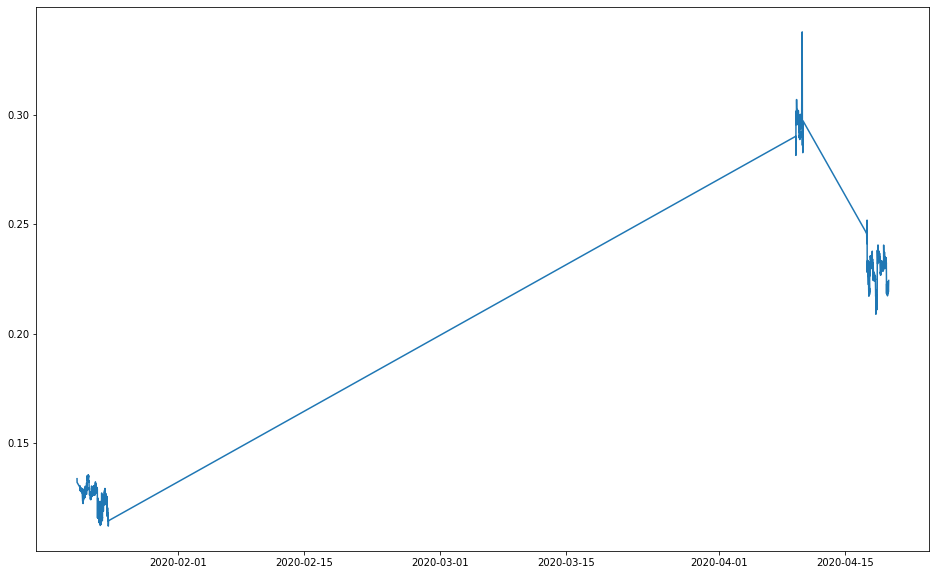

In [93]:
plt.plot(indices_df['vxbt'])

Text(0.5, 0.98, 'Volatility Time Series (2020-04-17 00:00:00-)')

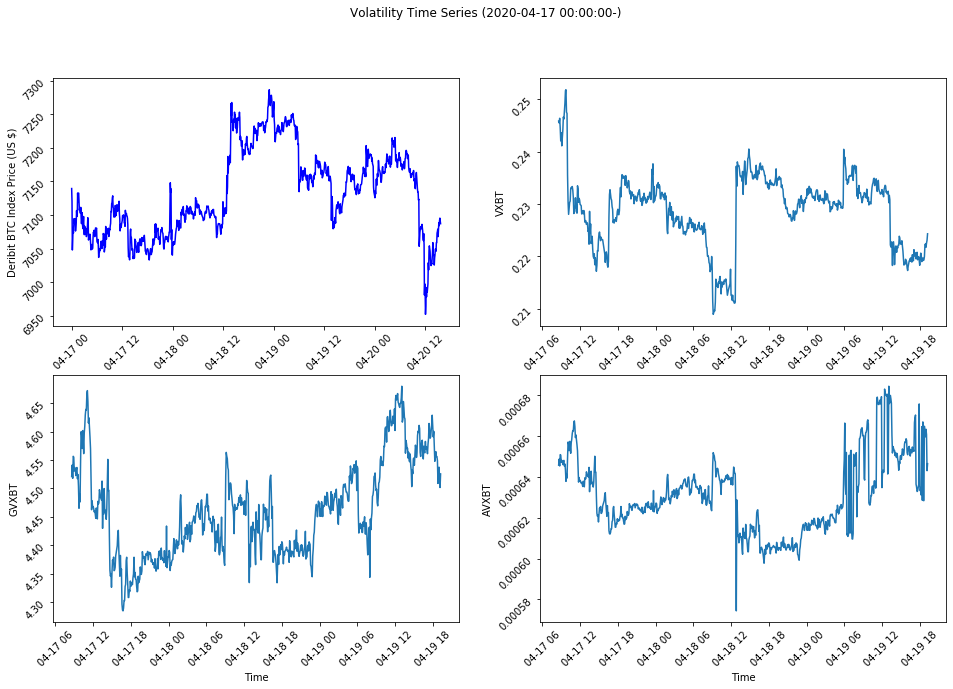

In [132]:
fig, ax =  plt.subplots(2,2)

plot_start = '2020-04-17 00:00:00'

ax[0][0].plot(index_prices_5min[plot_start:], color='blue')
ax[0][0].set_xlabel('Time')
ax[0][0].set_ylabel('Deribit BTC Index Price (US $)')
ax[0][0].tick_params(labelrotation=45)

ax[0][1].plot(indices_df['vxbt'][plot_start:])
ax[0][1].set_xlabel('Time')
ax[0][1].set_ylabel('VXBT')
ax[0][1].tick_params(labelrotation=45)

ax[1][0].plot(indices_df['gvxbt'][plot_start:])
ax[1][0].set_xlabel('Time')
ax[1][0].set_ylabel('GVXBT')
ax[1][0].tick_params(labelrotation=45)

ax[1][1].plot(indices_df['avxbt'][plot_start:])
ax[1][1].set_xlabel('Time')
ax[1][1].set_ylabel('AVXBT')
ax[1][1].tick_params(labelrotation=45)

fig.suptitle(f'Volatility Time Series ({plot_start}-)')

### Volatility index time series from live calculator

In [165]:
live_df = pd.read_csv('live_indices.csv').drop(['index_usd'], axis=1)
live_df['timestamp'] = pd.to_datetime(live_df['timestamp'])
live_df = live_df.set_index('timestamp')
live_df

,vxbt,gvxbt,avxbt
timestamp,,,
2020-04-19 20:05:00,0.224655,4.558362,0.000651
2020-04-19 20:06:00,0.223939,4.555675,0.000651
2020-04-19 20:07:00,0.225939,4.523634,0.000646
2020-04-19 20:08:00,0.225909,4.527518,0.000647
2020-04-19 20:09:00,0.225865,4.525514,0.000647
...,...,...,...
2020-04-23 11:51:00,0.202328,4.404012,0.000607
2020-04-23 11:52:00,0.203714,4.401960,0.000632
2020-04-23 11:53:00,0.202933,4.391715,0.000631


In [166]:
both_df = pd.concat([indices_df, live_df])
both_df

,vxbt,gvxbt,avxbt
timestamp,,,
2020-01-20 18:30:00,0.133866,3.578525,0.000409
2020-01-20 18:35:00,0.133152,3.559890,0.000407
2020-01-20 18:40:00,0.132163,3.543612,0.000405
2020-01-21 02:00:00,0.130005,3.532216,0.000404
2020-01-21 02:05:00,0.130069,3.540029,0.000405
...,...,...,...
2020-04-23 11:51:00,0.202328,4.404012,0.000607
2020-04-23 11:52:00,0.203714,4.401960,0.000632
2020-04-23 11:53:00,0.202933,4.391715,0.000631


Text(0.5, 0.98, 'Volatility Time Series (2020-04-17 00:00:00-)')

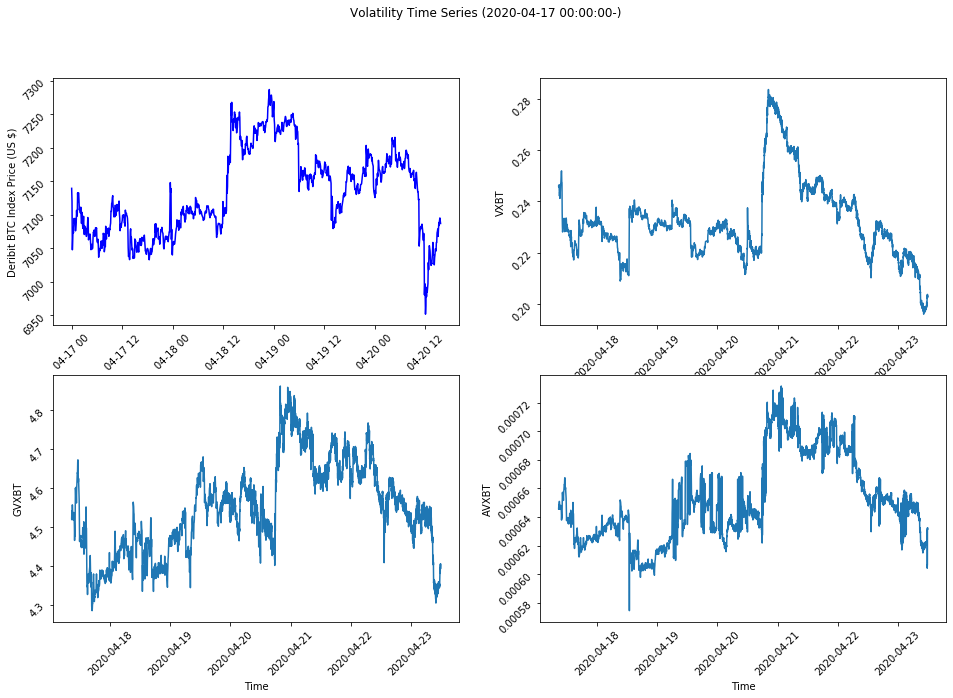

In [167]:
fig, ax =  plt.subplots(2,2)

#plot_start = live_df.index[0]

ax[0][0].plot(index_prices_5min[plot_start:], color='blue')
ax[0][0].set_xlabel('Time')
ax[0][0].set_ylabel('Deribit BTC Index Price (US $)')
ax[0][0].tick_params(labelrotation=45)

ax[0][1].plot(both_df['vxbt'][plot_start:])
ax[0][1].set_xlabel('Time')
ax[0][1].set_ylabel('VXBT')
ax[0][1].tick_params(labelrotation=45)

ax[1][0].plot(both_df['gvxbt'][plot_start:])
ax[1][0].set_xlabel('Time')
ax[1][0].set_ylabel('GVXBT')
ax[1][0].tick_params(labelrotation=45)

ax[1][1].plot(both_df['avxbt'][plot_start:])
ax[1][1].set_xlabel('Time')
ax[1][1].set_ylabel('AVXBT')
ax[1][1].tick_params(labelrotation=45)

fig.suptitle(f'Volatility Time Series ({plot_start}-)')

### Export for use in ARIMA/regression models

In [168]:
both_df[plot_start:].to_csv('volatility_data.csv')